In [11]:
# -*- coding: utf-8 -*-
"""GNN Model.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1pSO-VEyn5Cywjw9sXKn2fjXdVbI3hAsH
"""

# -*- coding: utf-8 -*-
"""Untitled2.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/193StgLnr4doKklAxwBiQsVX3njEfb1oa
"""


DATA_PATH = r"C:\Users\hu4227mo-s\OneDrive - Lund University\Merged_Data.csv"

In [12]:
!pip install vmdpy
from vmdpy import VMD 

Defaulting to user installation because normal site-packages is not writeable


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime, timedelta
import warnings
import sys
sys.path.append('/kaggle/input/vmdpy')  # Adjust the path if needed

warnings.filterwarnings('ignore')


# Check for GPU and set device appropriately for Kaggle T4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set optimized CUDA options for T4 GPU
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False  # Better performance but less reproducible
    # Set to float16 precision for faster computation on T4 GPU
    torch.set_float32_matmul_precision('high')

# ============================================================
# MODIFIED DATA LOADING AND PROCESSING FOR TARGETED SEASONAL ANALYSIS
# ============================================================

def load_data(file_path):
    """
    Load weather data, clean missing values, and filter to San Jose only.
    """
    try:
        # Determine file type and read
        if file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path, engine='openpyxl')
        else:
            df = pd.read_csv(file_path, encoding='ISO-8859-1')
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()  # Return empty DataFrame

    # Convert timestamp
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    elif 'DATE' in df.columns:
        df['timestamp'] = pd.to_datetime(df['DATE'])
        df = df.rename(columns={'DATE': 'date_original'})

    # Ensure time-based ordering before interpolation
    df = df.sort_values(by='timestamp')

    # Add hour of day feature - sine/cosine encoding for cyclical pattern
    df['hour_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.hour / 24)

    # Add day of year feature - sine/cosine encoding for cyclical pattern
    df['day_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.dayofyear / 365.25)
    df['day_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.dayofyear / 365.25)

    # Define region mapping for LA Downtown only
    region_mapping = {
        'San Jose': 'urban'
    }

    # Filter to keep only LA Downtown
    if 'station_id' in df.columns:
        # Filter to LA Downtown only
        df = df[df['station_id'] == 'San Jose']
        
        # Add region information
        df['region'] = df['station_id'].map(region_mapping)

        # Convert region to numerical encoding
        region_to_num = {region: i for i, region in enumerate(df['region'].unique())}
        df['region_code'] = df['region'].map(region_to_num)

        # Add elevation for LA Downtown
        elevation_mapping = {
            'San Jose': 93         # meters
        }
        df['elevation'] = df['station_id'].map(elevation_mapping)
        # Normalize elevation (will be constant for single station)
        df['elevation_norm'] = 0.0  # Since we only have one station, just use 0 as normalized value

        print(f"Filtered data to San Jose only")

    # Interpolate missing values along the time dimension
    df.interpolate(method='linear', limit_direction='both', inplace=True)

    return df

# ============================================================
# VMD DECOMPOSITION
# ============================================================

import multiprocessing
import joblib
import os

def perform_vmd_decomposition(signal, alpha=2000, tau=0, K=10, DC=0, init=1, tol=1e-7):
    """
    Perform VMD decomposition on a signal.
    """
    # Run VMD
    u, u_hat, omega = VMD(signal, alpha, tau, K, DC, init, tol)
    
    # Calculate reconstruction residual
    recon = np.sum(u, axis=0)
    rres = np.sqrt(np.mean((signal - recon)**2)) / np.sqrt(np.mean(signal**2)) * 100
    
    return u, rres

def find_optimal_k(signal, k_range=range(6, 15)):
    """
    Find optimal K where rres < 3% with no sharp drop.
    """
    results = []
    
    for k in k_range:
        print(f"  Testing K={k}")
        _, rres = perform_vmd_decomposition(signal, K=k)
        results.append((k, rres))
        print(f"  K={k}, rres={rres:.2f}%")
        if rres < 3.0:
            return k, rres
            
    # If no K achieves rres < 3%, return the K with lowest rres
    return min(results, key=lambda x: x[1])

def decompose_station_data(data, feature_name, station_id, cache_dir='vmd_cache'):
    """
    Decompose time series data for a single station.
    """
    print(f"Starting decomposition for {station_id} - {feature_name}")
    
    # Create cache directory if it doesn't exist
    os.makedirs(cache_dir, exist_ok=True)
    
    # Create a unique cache filename
    cache_file = f"{cache_dir}/vmd_{station_id}_{feature_name}.joblib"
    
    # Check if cached results exist
    if os.path.exists(cache_file):
        print(f"Loading cached VMD decomposition for {station_id} - {feature_name}")
        return joblib.load(cache_file)
    
    # Get the time series to decompose
    print(f"  Extracting signal for {station_id}")
    signal = data[feature_name].values
    
    # Normalize signal
    print(f"  Normalizing signal")
    signal_norm = (signal - np.mean(signal)) / np.std(signal)
    
    # Find optimal K
    print(f"  Finding optimal K")
    k_opt, rres = find_optimal_k(signal_norm)
    print(f"Station {station_id}, feature {feature_name}: Optimal K={k_opt}, rres={rres:.2f}%")
    
    # Perform VMD with optimal K
    print(f"  Performing VMD with K={k_opt}")
    u, _ = perform_vmd_decomposition(signal_norm, K=k_opt)
    
    # Denormalize modes
    print(f"  Denormalizing modes")
    u_denorm = u * np.std(signal) + np.mean(signal) / k_opt
    
    # Save to cache
    print(f"  Saving to cache: {cache_file}")
    joblib.dump(u_denorm, cache_file)
    
    print(f"Completed decomposition for {station_id} - {feature_name}")
    return u_denorm

def parallel_vmd_decomposition(df, feature_cols_to_decompose=['Temperature_C']):
    """
    Apply VMD decomposition to multiple stations serially to avoid multiprocessing issues.
    """
    # Get the unique station IDs 
    station_ids = ['San Jose']  # We only have LA Downtown in this code
    
    decomposed_data = {}
    
    for feature in feature_cols_to_decompose:
        print(f"Performing VMD decomposition for feature: {feature}")
        
        # Process each station serially instead of in parallel
        results = []
        for station_id in station_ids:
            print(f"  Processing station: {station_id}")
            result = decompose_station_data(df, feature, station_id)
            results.append(result)
            
        # Store results
        for i, station_id in enumerate(station_ids):
            if station_id not in decomposed_data:
                decomposed_data[station_id] = {}
            decomposed_data[station_id][feature] = results[i]
    
    return decomposed_data

def extract_target_days(df):
    """
    Extract the 4 specific target days (one per season) for predictions
    """
    # Define target days
    target_days = [
        {'season': 'Spring', 'month': 4, 'day': 15},  # April 15
        {'season': 'Summer', 'month': 7, 'day': 20},  # July 20
        {'season': 'Fall', 'month': 10, 'day': 10},   # October 10
        {'season': 'Winter', 'month': 1, 'day': 15}   # January 15
    ]

    # Filter for each target day
    target_data = {}
    for target in target_days:
        # Filter by month and day
        day_data = df[(df['timestamp'].dt.month == target['month']) &
                       (df['timestamp'].dt.day == target['day'])]

        # Get the most recent year that has data for this day
        if not day_data.empty:
            latest_year = day_data['timestamp'].dt.year.max()
            target_day_data = day_data[day_data['timestamp'].dt.year == latest_year]
            target_data[target['season']] = target_day_data
            print(f"Found {len(target_day_data)} records for {target['season']} target day ({target['month']}/{target['day']}/{latest_year})")
        else:
            print(f"WARNING: No data found for {target['season']} target day")

    return target_data

def prepare_seasonal_training_data(df, target_days):
    """
    For each target day, prepare all historical data for training
    """
    training_sets = {}

    for season, target_day_data in target_days.items():
        if target_day_data.empty:
            continue

        # Get the date of this target
        sample_date = target_day_data['timestamp'].iloc[0]
        target_year = sample_date.year

        # Use all historical data prior to the target year
        historical_data = df[df['timestamp'].dt.year < target_year]

        training_sets[season] = historical_data
        print(f"{season} training set: {len(historical_data)} samples from all historical data")

    return training_sets

def split_data_by_years(df):
    """
    Split the data into training, validation and test sets based on years.
    - Training: 2021-2022
    - Validation: 2023
    - Test: 2024
    """
    print("Splitting data by years...")
    
    # Create the splits
    train_df = df[(df['timestamp'].dt.year >= 2021) & (df['timestamp'].dt.year <= 2022)]
    val_df = df[df['timestamp'].dt.year == 2023]
    test_df = df[df['timestamp'].dt.year == 2024]
    
    # Print split sizes
    print(f"Training data (2021-2022): {len(train_df)} samples")
    print(f"Validation data (2023): {len(val_df)} samples")
    print(f"Test data (2024): {len(test_df)} samples")
    
    return train_df, val_df, test_df

def normalize_features(train_df, val_df, feature_cols):
    """
    Normalize features using StandardScaler fitted on training data
    """
    scaler = StandardScaler()

    # Fit on training data
    scaler.fit(train_df[feature_cols])

    # Transform datasets
    train_scaled = scaler.transform(train_df[feature_cols])
    val_scaled = scaler.transform(val_df[feature_cols])

    # Convert back to DataFrames
    train_norm = pd.DataFrame(train_scaled, columns=feature_cols, index=train_df.index)
    val_norm = pd.DataFrame(val_scaled, columns=feature_cols, index=val_df.index)

    return train_norm, val_norm, scaler

class WeatherDataset(Dataset):
    """
    Dataset for weather forecasting with sliding window approach.
    Modified to work efficiently with single station San Jose.
    """
    def __init__(self, df, station_ids, feature_cols, seq_length=24, forecast_horizon=24):
        """
        Args:
            df: DataFrame with weather data (filtered to San Jose only)
            station_ids: List containing only 'San Jose'
            feature_cols: List of feature columns to use as input
            seq_length: Length of input sequence (in hours)
            forecast_horizon: How many hours ahead to predict
        """
        self.df = df
        self.station_ids = station_ids
        self.feature_cols = feature_cols
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon
        self.n_stations = len(station_ids)  # Should be 1

        # Get unique timestamps (now all from one station)
        self.timestamps = sorted(df['timestamp'].unique())

        # Filter valid timestamps (those that have enough history and future data)
        valid_idx = []
        for i in range(len(self.timestamps) - (seq_length + forecast_horizon - 1)):
            # Check if we have continuous data for this window
            current_time = self.timestamps[i]
            end_time = self.timestamps[i + seq_length + forecast_horizon - 1]
            expected_duration = timedelta(hours=seq_length + forecast_horizon - 1)

            if (end_time - current_time) == expected_duration:
                valid_idx.append(i)

        self.valid_indices = valid_idx

        # Add a safety check to ensure we have at least one valid window
        if len(self.valid_indices) == 0:
            print(f"WARNING: No valid windows found in dataset. Using reduced requirements.")
            # Fall back to allowing any windows where we have both input and output data
            valid_idx = []
            for i in range(len(self.timestamps) - seq_length):
                if i + seq_length < len(self.timestamps):
                    valid_idx.append(i)
            self.valid_indices = valid_idx
            self.fallback_mode = True
            print(f"Found {len(self.valid_indices)} windows with relaxed continuity requirements")
        else:
            self.fallback_mode = False
            print(f"Created dataset with {len(self.valid_indices)} valid windows")

    def __len__(self):
        return max(1, len(self.valid_indices))  # Ensure length is at least 1

    def __getitem__(self, idx):
        if len(self.valid_indices) == 0:
            # Return dummy data if no valid indices
            X = np.zeros((len(self.feature_cols), self.n_stations, self.seq_length))
            y = np.zeros((self.n_stations, self.forecast_horizon))
            static_features = np.zeros((self.n_stations, 2))  # region_code and elevation
            return (torch.FloatTensor(X), torch.FloatTensor(static_features)), torch.FloatTensor(y)

        # Get actual data when possible
        start_idx = self.valid_indices[idx % len(self.valid_indices)]

        # Get timestamps for input and output windows
        input_timestamps = self.timestamps[start_idx:start_idx + self.seq_length]
        output_timestamps = self.timestamps[start_idx + self.seq_length:
                                            start_idx + self.seq_length + self.forecast_horizon]

        # Handle potential shortfall in output window (fallback mode)
        if self.fallback_mode and len(output_timestamps) < self.forecast_horizon:
            # Pad with repetition of last timestamp if needed
            last_time = output_timestamps[-1] if len(output_timestamps) > 0 else input_timestamps[-1]
            padding = [last_time] * (self.forecast_horizon - len(output_timestamps))
            output_timestamps = list(output_timestamps) + padding

        # Initialize tensors - simpler now with just one station
        X = np.zeros((len(self.feature_cols), 1, self.seq_length))  # Only one station
        y = np.zeros((1, self.forecast_horizon))  # Only one station
        static_features = np.zeros((1, 2))  # region_code and elevation

        # LA Downtown is our only station
        station_id = 'San Jose'
        
        # Input sequence
        for t_idx, ts in enumerate(input_timestamps):
            station_data = self.df[self.df['timestamp'] == ts]

            if not station_data.empty:
                for f_idx, feat in enumerate(self.feature_cols):
                    X[f_idx, 0, t_idx] = station_data[feat].values[0]

                # Store static features (same for all timestamps)
                if t_idx == 0:
                    static_features[0, 0] = station_data['region_code'].values[0]
                    static_features[0, 1] = station_data['elevation_norm'].values[0]

        # Target sequence (temperature only)
        for t_idx, ts in enumerate(output_timestamps):
            if t_idx < self.forecast_horizon:  # Safety check
                station_data = self.df[self.df['timestamp'] == ts]

                if not station_data.empty:
                    y[0, t_idx] = station_data['Temperature_C'].values[0]

        return (torch.FloatTensor(X), torch.FloatTensor(static_features)), torch.FloatTensor(y)
# ============================================================
# TEMPORAL FUSION TRANSFORMER IMPLEMENTATION
# ============================================================
class TemporalSelfAttention(nn.Module):
    """
    Multi-head self-attention layer for temporal data.
    Simplified from the original TFT paper.
    """
    def __init__(self, d_model, n_heads=2, dropout=0.1):
        super(TemporalSelfAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        # Linear projections
        queries = self.query(x).view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)
        keys = self.key(x).view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)
        values = self.value(x).view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / np.sqrt(self.head_dim)
        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)

        # Apply attention to values
        out = torch.matmul(attention, values)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

        # Final linear layer
        return self.out(out)

class GatedResidualNetwork(nn.Module):
    """
    Gated Residual Network as described in the TFT paper.
    Simplified version with fewer layers.
    """
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super(GatedResidualNetwork, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        # If input and output sizes are different, apply a skip connection
        self.skip_layer = None
        if input_size != output_size:
            self.skip_layer = nn.Linear(input_size, output_size)

        # Main layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.gate = nn.Linear(input_size + output_size, output_size)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(output_size)

    def forward(self, x):
        # Main branch
        hidden = F.elu(self.fc1(x))
        hidden = self.dropout(hidden)
        hidden = self.fc2(hidden)

        # Skip connection
        if self.skip_layer is not None:
            skip = self.skip_layer(x)
        else:
            skip = x

        # Gate mechanism
        gate_input = torch.cat([x, hidden], dim=-1)
        gate = torch.sigmoid(self.gate(gate_input))

        # Combine using gate
        output = gate * hidden + (1 - gate) * skip

        # Layer normalization
        return self.layer_norm(output)

class VariableSelectionNetwork(nn.Module):
    """
    Variable Selection Network for TFT.
    Simplified version with fewer layers.
    """
    def __init__(self, input_size_per_var, num_vars, hidden_size, output_size, dropout=0.1):
        super(VariableSelectionNetwork, self).__init__()
        self.input_size_per_var = input_size_per_var
        self.num_vars = num_vars
        self.hidden_size = hidden_size
        self.output_size = output_size

        # GRN for variable weights
        self.weight_grn = GatedResidualNetwork(
            input_size=input_size_per_var * num_vars,
            hidden_size=hidden_size,
            output_size=num_vars,
            dropout=dropout
        )

        # GRN for each variable
        self.var_grns = nn.ModuleList([
            GatedResidualNetwork(
                input_size=input_size_per_var,
                hidden_size=hidden_size,
                output_size=output_size,
                dropout=dropout
            ) for _ in range(num_vars)
        ])

    def forward(self, x):
        # x shape: [batch_size, num_vars, input_size_per_var]
        batch_size = x.size(0)
        flat_x = x.view(batch_size, -1)

        # Calculate variable weights
        var_weights = self.weight_grn(flat_x)
        var_weights = F.softmax(var_weights, dim=-1).unsqueeze(-1)  # [batch_size, num_vars, 1]

        # Transform each variable
        var_outputs = []
        for i in range(self.num_vars):
            var_outputs.append(self.var_grns[i](x[:, i]))

        var_outputs = torch.stack(var_outputs, dim=1)  # [batch_size, num_vars, output_size]

        # Weighted combination
        outputs = torch.sum(var_outputs * var_weights, dim=1)  # [batch_size, output_size]

        return outputs, var_weights

class TemporalFusionTransformer(nn.Module):
    """
    Temporal Fusion Transformer with single predictions (no quantiles).
    """
    def __init__(self, num_features, num_stations, hidden_size=64, num_heads=1, 
                 dropout=0.1, forecast_horizon=24, hidden_layers=2):
        super(TemporalFusionTransformer, self).__init__()
        self.num_features = num_features
        self.num_stations = num_stations
        self.hidden_size = hidden_size
        self.forecast_horizon = forecast_horizon
        self.hidden_layers = hidden_layers
        
        # Static variable processing
        self.static_var_processor = GatedResidualNetwork(
            input_size=2,  # region_code, elevation
            hidden_size=hidden_size,
            output_size=hidden_size,
            dropout=dropout
        )
        
        # Variable selection for time-varying features
        self.temporal_var_selection = VariableSelectionNetwork(
            input_size_per_var=24,  # Sequence length per feature
            num_vars=num_features,
            hidden_size=hidden_size,
            output_size=hidden_size,
            dropout=dropout
        )
        
        # LSTM encoder layers
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(
                input_size=hidden_size if i == 0 else hidden_size,
                hidden_size=hidden_size,
                batch_first=True
            ) for i in range(hidden_layers)
        ])
        
        # Temporal self-attention
        self.self_attention = TemporalSelfAttention(
            d_model=hidden_size,
            n_heads=num_heads,
            dropout=dropout
        )
        
        # Final output layer for forecasting (single prediction)
        self.forecast_projection = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, forecast_horizon)
        )
        
    def forward(self, inputs):
        # Unpack inputs
        temporal_features, static_features = inputs
        batch_size = temporal_features.size(0)
        
        # [batch, features, stations, time] -> [batch*stations, features, time]
        temporal_features = temporal_features.permute(0, 2, 1, 3)
        temporal_features = temporal_features.reshape(batch_size * self.num_stations, self.num_features, -1)
        
        # Static features: [batch, stations, static_dims] -> [batch*stations, static_dims]
        static_features = static_features.reshape(batch_size * self.num_stations, -1)
        
        # Process static features
        static_embeddings = self.static_var_processor(static_features)
        
        # Process temporal features with variable selection
        temporal_embeddings, temporal_weights = self.temporal_var_selection(temporal_features)
        
        # Reshape to [batch*stations, seq_len, hidden]
        temporal_embeddings = temporal_embeddings.unsqueeze(1).expand(-1, 24, -1)
        
        # Add static embeddings to each timestep
        temporal_embeddings = temporal_embeddings + static_embeddings.unsqueeze(1)
        
        # Pass through LSTM layers
        lstm_out = temporal_embeddings
        for lstm_layer in self.lstm_layers:
            lstm_out, _ = lstm_layer(lstm_out)
        
        # Self-attention
        attention_out = self.self_attention(lstm_out)
        
        # Generate forecast
        forecast = self.forecast_projection(attention_out)
        
        # Take the last timesteps for the forecast horizon
        forecast = forecast[:, -self.forecast_horizon:, 0]
        
        # Reshape back to [batch, stations, horizon]
        forecast = forecast.reshape(batch_size, self.num_stations, -1)
        
        return forecast
        
# ============================================================
# ADE OPTIMIZATION
# ============================================================
import random
from functools import partial



import torch
import numpy as np
import os
import time
from functools import partial
    
def train_model(model, train_loader, val_loader, learning_rate=0.001, epochs=30, patience=5, use_checkpoint=True):
    """
    Train the model with MSE loss and early stopping.
    """
    model.to(device)
    
    checkpoint_path = 'checkpoint.pth'
    # Add a model version identifier to prevent future mismatches
    model_version = "single_output_v1"  # Change this when architecture changes
    start_epoch = 0
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Initialize optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # Simple checkpoint loading
    if os.path.exists(checkpoint_path) and use_checkpoint:
        try:
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming training from epoch {start_epoch}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
    
    # Add mixed precision training with autocast
    scaler = torch.cuda.amp.GradScaler()

    train_losses = []
    val_losses = []

    print(f"Starting training for {epochs} epochs with patience {patience}...")
    total_start_time = time.time()

    for epoch in range(start_epoch, epochs):
        # Training
        model.train()
        train_loss = 0
        train_batches = 0

        for inputs, targets in train_loader:
            # Move to device
            if isinstance(inputs, tuple):
                inputs = tuple(x.to(device) for x in inputs)
            elif isinstance(inputs, list):
                inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs]
            else:
                inputs = inputs.to(device)

            targets = targets.to(device)

            # Forward pass with mixed precision
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = F.mse_loss(outputs, targets)

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            train_batches += 1
            
        avg_train_loss = train_loss / max(1, train_batches)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        val_batches = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                # Move to device
                if isinstance(inputs, tuple):
                    inputs = tuple(x.to(device) for x in inputs)
                elif isinstance(inputs, list):
                    inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs]
                else:
                    inputs = inputs.to(device)
                    
                targets = targets.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = F.mse_loss(outputs, targets)

                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / max(1, val_batches)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Learning rate scheduler
        scheduler.step(avg_val_loss)

        if use_checkpoint and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save({
                'model_state_dict': model.state_dict(),
                'epoch': epoch,
                'model_version': model_version
            }, checkpoint_path)
            print(f"  Saved best model with val loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    total_time = time.time() - total_start_time
    print(f"Training completed in {total_time/60:.2f} minutes")
    
    # Load best model
    if use_checkpoint and os.path.exists(checkpoint_path):
        try:
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded best model")
        except Exception as e:
            print(f"Error loading best model: {e}")

    return model, train_losses, val_losses

def evaluate_model(model, data_loader, station_ids, regions):
    """
    Evaluate the model and calculate metrics with robust dimension handling.
    """
    model.eval()
    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Move to device - handle ALL possible input types
            if isinstance(inputs, tuple):
                inputs = tuple(x.to(device) for x in inputs)
            elif isinstance(inputs, list):
                inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs]
            else:
                inputs = inputs.to(device)

            # Forward pass with mixed precision for evaluation
            with torch.cuda.amp.autocast():
                outputs = model(inputs)

            # Me i changed the median preds with preds instead 
            preds = outputs.detach().cpu().numpy()
            targets_cpu = targets.numpy()
            
            # Append batch predictions and targets
            all_predictions.append(preds)
            all_actuals.append(targets_cpu)
            
            # Clear GPU cache periodically
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # Process predictions in chunks to save memory
    rmse_sum = 0
    mae_sum = 0
    r2_sum = 0
    sample_count = 0
    
    # Process in smaller chunks
    for preds, acts in zip(all_predictions, all_actuals):
        # Flatten current batch
        preds_flat = preds.flatten()  
        acts_flat = acts.flatten()
        
        # Update metrics
        rmse_sum += np.sum((preds_flat - acts_flat) ** 2)
        mae_sum += np.sum(np.abs(preds_flat - acts_flat))
        sample_count += len(preds_flat)
    
    # Calculate final metrics
    rmse = np.sqrt(rmse_sum / sample_count)
    mae = mae_sum / sample_count
    
    # For R², we need all data (this is an approximation)
    all_preds_concat = np.concatenate([p.flatten() for p in all_predictions])
    all_acts_concat = np.concatenate([a.flatten() for a in all_actuals])
    r2 = r2_score(all_acts_concat, all_preds_concat)

    print(f"Overall Metrics - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # Since we only have one station San Jose, simplify the station metrics
    station_metrics = {
        station_ids[0]: {
            'region': regions.get(station_ids[0], 'Unknown'),
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
    }
    
    print(f"Station {station_ids[0]} ({regions.get(station_ids[0], 'Unknown')}) - "
          f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    return rmse, mae, r2, station_metrics

def visualize_predictions(model, data_loader, station_ids, regions, season):
    """
    Visualize predictions for each station.
    """
    model.eval()
    if len(data_loader) == 0:
        print("No data available for visualization")
        return
    
    # Get predictions
    try:
        for inputs, targets in data_loader:
            # Only process one batch for visualization
            if isinstance(inputs, tuple):
                inputs = tuple(x.to(device) for x in inputs)
            else:
                inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            # Move to CPU for plotting
            outputs = outputs.cpu().numpy()
            targets = targets.numpy()
            break

        # Check if we have data to plot
        if 'outputs' not in locals():
            print("No data was loaded from the dataloader")
            return
    except Exception as e:
        print(f"Error processing visualization data: {e}")
        return
    
    # Create subplots for each station
    fig, axes = plt.subplots(len(station_ids), 1, figsize=(12, 3*len(station_ids)))
    if len(station_ids) == 1:
        axes = [axes]

    hours = np.arange(24)

    for i, station in enumerate(station_ids):
        ax = axes[i]

        # Plot actual vs predicted
        ax.plot(hours, targets[0, i, :], 'b-', label='Actual')
        ax.plot(hours, outputs[0, i, :], 'r--', label='Predicted')

        ax.set_title(f"{station} ({regions.get(station, 'Unknown')}) - {season}")
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{season}_predictions.png")
    plt.show()  # Add this line to display the plot
    plt.close()

def predict_day_temperatures(model, day_data, feature_cols):
    """
    Predict temperatures for a single day (24 hours).
    
    Args:
        model: Trained TFT model
        day_data: DataFrame with data for the target day
        feature_cols: List of feature columns used by the model
        
    Returns:
        Predicted temperatures for 24 hours
    """
    model.eval()
    
    # Prepare input data format (same as in create_seasonal_datasets)
    try:
        # Format data for model input
        temporal_data = np.zeros((1, len(feature_cols), 1, 24))  # [batch=1, features, stations=1, time=24]
        
        # Fill temporal features
        for f_idx, feat in enumerate(feature_cols):
            if feat in day_data.columns:
                temporal_data[0, f_idx, 0, :] = day_data[feat].values[:24]
        
        # Create static features
        static_data = np.zeros((1, 1, 2))  # [batch=1, stations=1, static_features=2]
        static_data[0, 0, 0] = day_data['region_code'].iloc[0] 
        static_data[0, 0, 1] = day_data['elevation_norm'].iloc[0]
        
        # Convert to tensors
        X_temporal = torch.FloatTensor(temporal_data).to(device)
        X_static = torch.FloatTensor(static_data).to(device)
        
        # Make prediction
        with torch.no_grad():
            prediction = model((X_temporal, X_static))
            
        # Return prediction as numpy array
        return prediction.cpu().numpy()[0, 0, :]
        
    except Exception as e:
        print(f"Error predicting temperatures: {e}")
        import traceback
        traceback.print_exc()
        return None
    
def plot_temperature_prediction(actual, predicted, date_str=None):
    """
    Plot actual vs predicted temperatures.
    
    Args:
        actual: Numpy array of actual temperatures (24 hours)
        predicted: Numpy array of predicted temperatures (24 hours)
        date_str: String representation of the date
    """
    hours = np.arange(24)
    
    plt.figure(figsize=(12, 6))
    plt.plot(hours, actual, 'b-o', label='Actual Temperature', linewidth=2)
    plt.plot(hours, predicted, 'r-o', label='Predicted Temperature', linewidth=2)
    
    title = f"Daily Temperature Forecast" 
    if date_str:
        title += f" for {date_str}"
    
    plt.title(title, fontsize=16)
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Temperature (°C)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(hours)
    
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    filename = f"temperature_forecast_{date_str.replace(' ', '_').replace(':', '-')}.png" if date_str else "temperature_forecast.png"
    plt.show()

def create_mirror_plot(model, data_loader, station_ids, regions, season):
    """
    Create a mirror plot with actual temperature on left side and predicted on right side.
    """
    model.eval()
    if len(data_loader) == 0:
        print(f"No data available for {season} mirror plot")
        return
    
    # Get predictions
    try:
        for inputs, targets in data_loader:
            # Move inputs to device - handle ALL possible input types
            if isinstance(inputs, tuple):
                inputs = tuple(x.to(device) for x in inputs)
            elif isinstance(inputs, list):
                inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs]
            else:
                inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            # Move to CPU for plotting
            outputs = outputs.cpu().numpy()
            targets = targets.numpy()
            break
            
        if 'outputs' not in locals():
            print(f"No data was loaded for {season} mirror plot")
            return
    except Exception as e:
        print(f"Error processing mirror plot data for {season}: {e}")
        import traceback
        traceback.print_exc()  # Print full error details
        return
    
    # Create a figure for each station
    for i, station in enumerate(station_ids):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
        
        hours = np.arange(24)
        
        # Left plot - Actual temperatures
        ax1.plot(hours, targets[0, i, :], 'b-o', linewidth=2)
        ax1.set_title(f"Actual Temperature - {season}", fontsize=14)
        ax1.set_xlabel('Hour of Day', fontsize=12)
        ax1.set_ylabel('Temperature (°C)', fontsize=12)
        ax1.set_xlim(0, 23)
        ax1.grid(True, alpha=0.3)
        ax1.invert_xaxis()  # Invert x-axis for mirror effect
        
        # Right plot - Predicted temperatures
        ax2.plot(hours, outputs[0, i, :], 'r-o', linewidth=2)
        ax2.set_title(f"Predicted Temperature - {season}", fontsize=14)
        ax2.set_xlabel('Hour of Day', fontsize=12)
        ax2.set_xlim(0, 23)
        ax2.grid(True, alpha=0.3)
        
        # Add overall title
        plt.suptitle(f"{station} ({regions.get(station, 'Unknown')}) - {season} Day Comparison", 
                    fontsize=16, y=1.05)
        
        # Add a line in the middle
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.05)  # Reduce space between subplots
        
        # Save and display
        plt.savefig(f"{season}_mirror_comparison.png", bbox_inches='tight')
        plt.show()
        plt.close()

def create_seasonal_datasets(df, target_days, all_stations, feature_cols):
    """
    Create datasets for each seasonal day and visualize predictions.
    """
    seasonal_datasets = {}
    
    for season, day_data in target_days.items():
        if day_data.empty:
            print(f"No data available for {season}")
            continue
            
        # Get the date of this target day
        sample_date = day_data['timestamp'].iloc[0]
        print(f"Creating dataset for {season}: {sample_date.strftime('%Y-%m-%d')}")
        
        try:
            # Prepare the data in the format expected by the model
            # Format should be: temporal_features [batch, features, stations, time], static_features [batch, stations, static_features]
            
            # Reshape features to match expected format
            temporal_data = np.zeros((1, len(feature_cols), 1, 24))  # [batch=1, features, stations=1, time=24]
            
            # Fill in the temporal features
            for f_idx, feat in enumerate(feature_cols):
                if feat in day_data.columns:
                    temporal_data[0, f_idx, 0, :] = day_data[feat].values[:24]  # Using first 24 records
            
            # Create static features (region_code and elevation)
            static_data = np.zeros((1, 1, 2))  # [batch=1, stations=1, static_features=2]
            static_data[0, 0, 0] = day_data['region_code'].iloc[0] 
            static_data[0, 0, 1] = day_data['elevation_norm'].iloc[0]
            
            # Create target (actual temperatures)
            target_data = np.zeros((1, 1, 24))  # [batch=1, stations=1, time=24]
            target_data[0, 0, :] = day_data['Temperature_C'].values[:24]  # Using first 24 records
            
            # Convert to tensors
            X_temporal = torch.FloatTensor(temporal_data)
            X_static = torch.FloatTensor(static_data)
            y = torch.FloatTensor(target_data)
            
            # Store as a list containing a single data point
            seasonal_datasets[season] = [((X_temporal, X_static), y)]
            print(f"Created {season} dataset with shapes: X_temporal={X_temporal.shape}, X_static={X_static.shape}, y={y.shape}")
            
        except Exception as e:
            print(f"Error creating {season} dataset: {e}")
            import traceback
            traceback.print_exc()
    
    return seasonal_datasets


def analyze_topographic_performance(station_metrics, regions):
    """
    Analyze model performance across different topographic regions.
    """
    # Group metrics by region
    region_metrics = {}
    for station, metrics in station_metrics.items():
        region = regions.get(station, 'Unknown')
        if region not in region_metrics:
            region_metrics[region] = []
        region_metrics[region].append(metrics)

    # Calculate average metrics by region
    region_avg_metrics = {}
    for region, metrics_list in region_metrics.items():
        avg_rmse = np.mean([m['rmse'] for m in metrics_list])
        avg_mae = np.mean([m['mae'] for m in metrics_list])
        avg_r2 = np.mean([m['r2'] for m in metrics_list])

        region_avg_metrics[region] = {
            'avg_rmse': avg_rmse,
            'avg_mae': avg_mae,
            'avg_r2': avg_r2
        }

        print(f"Region {region} - Avg RMSE: {avg_rmse:.4f}, Avg MAE: {avg_mae:.4f}, Avg R²: {avg_r2:.4f}")

        if not station_metrics:
            print("No station metrics available for analysis")
            return {}

    # Create bar chart comparing regions
    regions = list(region_avg_metrics.keys())
    rmse_values = [region_avg_metrics[r]['avg_rmse'] for r in regions]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(regions, rmse_values)

    # Add styling
    plt.title('RMSE by Topographic Region', fontsize=16)

    plt.title('RMSE by Topographic Region', fontsize=16)
    plt.ylabel('RMSE (°C)', fontsize=14)
    plt.xlabel('Region', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.2f}',
                 ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()
    plt.savefig('region_performance.png')
    plt.close()

    return region_avg_metrics

def analyze_seasonal_performance(seasonal_results):
    """
    Compare model performance across different seasons.
    """
    seasons = list(seasonal_results.keys())
    rmse_values = [results['rmse'] for results in seasonal_results.values()]
    mae_values = [results['mae'] for results in seasonal_results.values()]

    if not seasonal_results:
        print("No seasonal results available for analysis")
        return [], [], []

    # Create grouped bar chart
    x = np.arange(len(seasons))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, rmse_values, width, label='RMSE')
    ax.bar(x + width/2, mae_values, width, label='MAE')

    ax.set_title('Model Performance by Season', fontsize=16)
    ax.set_ylabel('Error (°C)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(seasons)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add value labels
    for i, v in enumerate(rmse_values):
        ax.text(i - width/2, v + 0.1, f'{v:.2f}', ha='center', fontsize=10)

    for i, v in enumerate(mae_values):
        ax.text(i + width/2, v + 0.1, f'{v:.2f}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()
    plt.savefig('seasonal_performance.png')
    plt.close()

    return seasons, rmse_values, mae_values




Using device: cpu


In [16]:
# ============================================================
# BLOCK 1: INITIALIZATION AND DATA LOADING
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
from torch.utils.data import DataLoader, random_split

print("San Jose Weather Forecasting with VMD + TFT")
print("=" * 70)




def run_temperature_prediction(data_file, target_date=None):
    """
    Run the VMD-TFT temperature prediction pipeline.
    
    Args:
        data_file: Path to weather data file
        target_date: Optional datetime object for prediction target 
                     (if None, will use the latest available date in data)
    """
    print("Starting VMD-TFT temperature prediction pipeline...")
    
    df = load_data(data_file)
    print(f"Loaded data with {len(df)} records")
    if df.empty:
        print("Failed to load data. Exiting.")
        return
    
    # Split data by years
    train_df, val_df, test_df = split_data_by_years(df)
    
    # Define feature columns for the model
    feature_cols = [
    'Temperature_C',
    'HourlyRelativeHumidity',
    'HourlyStationPressure',
    'hour_sin', 'hour_cos',
    'day_sin', 'day_cos'
    ]
    
    # Perform VMD decomposition on temperature data
    print("Performing VMD decomposition...")
    decomposed_data = parallel_vmd_decomposition(df, feature_cols_to_decompose=['Temperature_C'])
    
    # Create datasets
    train_dataset = WeatherDataset(train_df, ['San Jose'], feature_cols, seq_length=24, forecast_horizon=24)
    val_dataset = WeatherDataset(val_df, ['San Jose'], feature_cols, seq_length=24, forecast_horizon=24)
    test_dataset = WeatherDataset(test_df, ['San Jose'], feature_cols, seq_length=24, forecast_horizon=24)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Create model
    model = TemporalFusionTransformer(
        num_features=len(feature_cols),
        num_stations=1,  # Just San Jose
        hidden_size=64,
        num_heads=1,
        dropout=0.1,
        forecast_horizon=24,
        hidden_layers=2
    )
    
    # Train model
    model, train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=0.001,
        epochs=30,
        patience=5
    )

        # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.title("Training vs Validation Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    # Evaluate model
    rmse, mae, r2, station_metrics = evaluate_model(model, test_loader, ['San Jose'], {'San Jose': 'urban'})
    
    # Predict for target date
    if target_date is None:
        # Use last day in dataset
        target_date = df['timestamp'].max().date()
        print(f"No target date specified. Using last day in dataset: {target_date}")
    
    # Filter data for target day
    target_day_data = df[df['timestamp'].dt.date == target_date].copy()
    
    if target_day_data.empty:
        print(f"No data available for date {target_date}")
        return
        
    # Ensure we have 24 hours of data
    if len(target_day_data) < 24:
        print(f"Warning: Only {len(target_day_data)} hours available for {target_date}. Need 24 hours.")
        return
        
    # Make prediction
    print(f"Predicting temperatures for {target_date}...")
    predicted_temps = predict_day_temperatures(model, target_day_data, feature_cols)
    
    if predicted_temps is not None:
        # Get actual temperatures
        actual_temps = target_day_data['Temperature_C'].values[:24]
        
        # Plot results
        plot_temperature_prediction(actual_temps, predicted_temps, str(target_date))
        
        # Print prediction results
        print("\nPrediction Results:")
        print(f"{'Hour':<5} {'Actual':<10} {'Predicted':<10} {'Difference':<10}")
        print("-" * 40)
        for hour in range(24):
            diff = predicted_temps[hour] - actual_temps[hour]
            print(f"{hour:<5} {actual_temps[hour]:<10.2f} {predicted_temps[hour]:<10.2f} {diff:<10.2f}")
            
        # Calculate error metrics for this prediction
        day_mse = np.mean((predicted_temps - actual_temps) ** 2)
        day_rmse = np.sqrt(day_mse)
        day_mae = np.mean(np.abs(predicted_temps - actual_temps))
        
        print(f"\nDay prediction errors - RMSE: {day_rmse:.2f}°C, MAE: {day_mae:.2f}°C")
    
    print("VMD-TFT prediction pipeline completed.")

San Jose Weather Forecasting with VMD + TFT


In [5]:
c = r"C:\Users\hu4227mo-s\OneDrive - Lund University\Merged_Data.csv"
run_temperature_prediction(c)

Starting VMD-TFT temperature prediction pipeline...
Filtered data to LA Downtown only
Loaded data with 35040 records
Splitting data by years...
Training data (2021-2022): 17496 samples
Validation data (2023): 8759 samples
Test data (2024): 8784 samples
Performing VMD decomposition...
Performing VMD decomposition for feature: Temperature_C
  Processing station: LA Downtown
Starting decomposition for LA Downtown - Temperature_C
Loading cached VMD decomposition for LA Downtown - Temperature_C
Created dataset with 17449 valid windows
Created dataset with 8665 valid windows
Created dataset with 8737 valid windows
Resuming training from epoch 5
Starting training for 5 epochs with patience 2...
Training completed in 0.00 minutes
Loaded best model
Overall Metrics - RMSE: 2.5100, MAE: 2.0850, R²: -0.4614
Station LA Downtown (urban) - RMSE: 2.5100, MAE: 2.0850, R²: -0.4614
No target date specified. Using last day in dataset: 2025-01-01


Starting VMD-TFT temperature prediction pipeline...
Filtered data to San Jose only
Loaded data with 35040 records
Splitting data by years...
Training data (2021-2022): 17496 samples
Validation data (2023): 8759 samples
Test data (2024): 8784 samples
Performing VMD decomposition...
Performing VMD decomposition for feature: Temperature_C
  Processing station: San Jose
Starting decomposition for San Jose - Temperature_C
Loading cached VMD decomposition for San Jose - Temperature_C
Created dataset with 17449 valid windows
Created dataset with 8665 valid windows
Created dataset with 8737 valid windows
Resuming training from epoch 15
Starting training for 30 epochs with patience 5...
Epoch 16/30
  Train Loss: 4.0516, Val Loss: 4.3692
  Saved best model with val loss: 4.3692
Epoch 17/30
  Train Loss: 3.9172, Val Loss: 4.5488
Epoch 18/30
  Train Loss: 3.8059, Val Loss: 4.2257
  Saved best model with val loss: 4.2257
Epoch 19/30
  Train Loss: 3.7346, Val Loss: 4.5248
Epoch 20/30
  Train Loss: 3

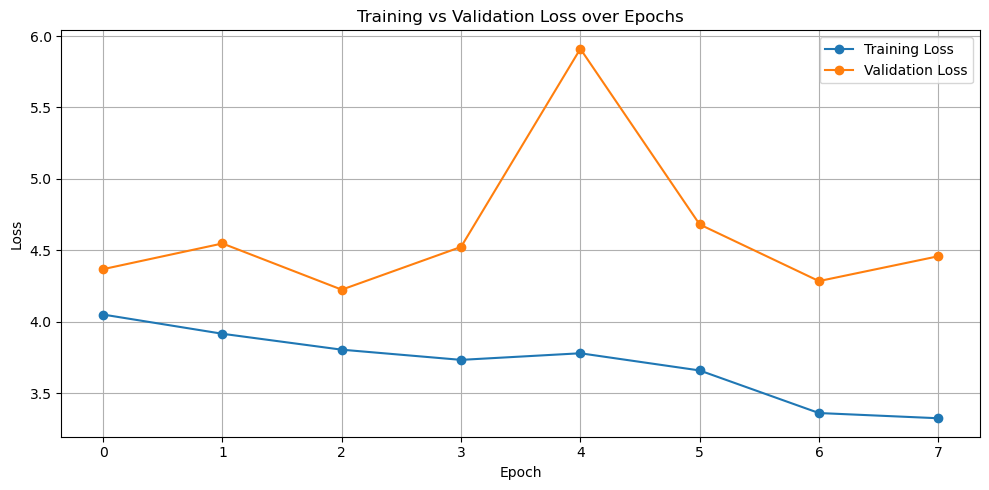

Overall Metrics - RMSE: 2.1970, MAE: 1.6441, R²: 0.8642
Station San Jose (urban) - RMSE: 2.1970, MAE: 1.6441, R²: 0.8642
Predicting temperatures for 2024-04-15...


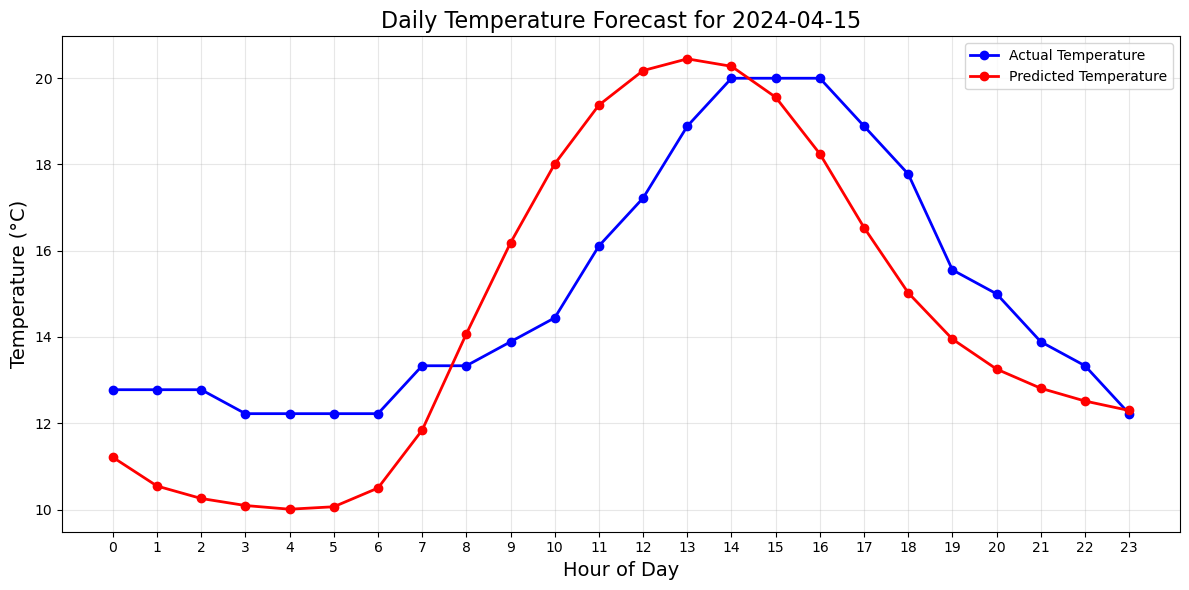


Prediction Results:
Hour  Actual     Predicted  Difference
----------------------------------------
0     12.78      11.21      -1.57     
1     12.78      10.54      -2.23     
2     12.78      10.26      -2.52     
3     12.22      10.09      -2.13     
4     12.22      10.01      -2.22     
5     12.22      10.06      -2.16     
6     12.22      10.50      -1.72     
7     13.33      11.84      -1.49     
8     13.33      14.07      0.74      
9     13.89      16.18      2.29      
10    14.44      18.01      3.57      
11    16.11      19.38      3.27      
12    17.22      20.18      2.96      
13    18.89      20.45      1.56      
14    20.00      20.28      0.28      
15    20.00      19.56      -0.44     
16    20.00      18.25      -1.75     
17    18.89      16.54      -2.35     
18    17.78      15.02      -2.75     
19    15.56      13.95      -1.61     
20    15.00      13.25      -1.75     
21    13.89      12.81      -1.08     
22    13.33      12.51      -0.82     
23

In [17]:
run_temperature_prediction(c, datetime(2024, 4, 15).date())

In [27]:
# ============================================================
# BLOCK 2: VMD DECOMPOSITION
# ============================================================

# Apply VMD decomposition to the Temperature_C feature
print("Performing VMD decomposition...")
decomposed_data = parallel_vmd_decomposition(df, feature_cols_to_decompose=['Temperature_C'])

# Expand feature columns with decomposed modes
expanded_feature_cols = feature_cols.copy()

# For LA Downtown, add decomposed temperature modes to feature columns
la_downtown_modes = decomposed_data['LA Downtown']['Temperature_C']
n_modes = la_downtown_modes.shape[0]  # Number of VMD modes

print(f"Found {n_modes} VMD modes for Temperature_C")

# Create expanded dataset with VMD modes
vmd_df = df.copy()

# Add VMD modes as new features
for i in range(n_modes):
    mode_name = f'Temp_Mode_{i+1}'
    vmd_df[mode_name] = la_downtown_modes[i, :]
    expanded_feature_cols.append(mode_name)

print("BLOCK 2 COMPLETED: VMD decomposition successful.")

Performing VMD decomposition...
Performing VMD decomposition for feature: Temperature_C
  Processing station: LA Downtown
Starting decomposition for LA Downtown - Temperature_C
Loading cached VMD decomposition for LA Downtown - Temperature_C
Found 14 VMD modes for Temperature_C
BLOCK 2 COMPLETED: VMD decomposition successful.


In [28]:
# ============================================================
# BLOCK 3: DATASET CREATION AND SPLITTING
# ============================================================

# Create dataset with expanded features
full_dataset = WeatherDataset(
    df=vmd_df,
    station_ids=all_stations,
    feature_cols=expanded_feature_cols,
    seq_length=24,
    forecast_horizon=24
)

# Split into train/val/test
dataset_size = len(full_dataset)
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size])

print(f"Dataset split completed - Train: {train_size}, Validation: {val_size}, Test: {test_size}")

# First, create data loaders with default batch size
initial_batch_size = 32  # Default value before optimization

train_loader = DataLoader(
    train_dataset, 
    batch_size=initial_batch_size, 
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=initial_batch_size, 
    shuffle=False,
    pin_memory=True,
    num_workers=2,
    persistent_workers=True
)

print("BLOCK 3 COMPLETED: Dataset creation and splitting successful.")


Created dataset with 34946 valid windows
Dataset split completed - Train: 24462, Validation: 5241, Test: 5243
BLOCK 3 COMPLETED: Dataset creation and splitting successful.


In [21]:
# Define the quick test function
def quick_test_run(train_loader, val_loader, feature_cols, num_stations):
    """Run a quick test to ensure training works."""
    print("Running quick test to verify checkpoint compatibility...")
    
    # Create a small model with fixed parameters
    test_model = TemporalFusionTransformer(
        num_features=len(feature_cols),
        num_stations=num_stations,
        hidden_size=24,
        num_heads=1,
        dropout=0.1,
        forecast_horizon=24,
        hidden_layers=2
    )
    
    # Train for only 2 epochs with early stopping disabled
    model, train_losses, val_losses = train_model(
        model=test_model,
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=0.01,
        epochs=2,  # Just 2 epochs for quick testing
        patience=5,  # High patience to avoid early stopping
        use_checkpoint=False  # Set to False to avoid checkpoint issues
    )
    
    print("Test run completed successfully!")
    return True

# First run the quick test to verify everything works
print("BLOCK 3.5: Running quick test before optimization...")
quick_test_run(train_loader, val_loader, expanded_feature_cols, len(all_stations))

BLOCK 3.5: Running quick test before optimization...
Running quick test to verify checkpoint compatibility...
Starting training from scratch.
Starting training for 2 epochs with patience 5...
  Batch 10/765, Loss: 188.5364, Time: 0.060s
  Batch 20/765, Loss: 24.3842, Time: 0.059s
  Batch 30/765, Loss: 22.0760, Time: 0.061s
  Batch 40/765, Loss: 20.5718, Time: 0.060s
  Batch 50/765, Loss: 27.9817, Time: 0.061s
  Batch 60/765, Loss: 21.1070, Time: 0.061s
  Batch 70/765, Loss: 19.5703, Time: 0.062s
  Batch 80/765, Loss: 24.9461, Time: 0.062s
  Batch 90/765, Loss: 20.9401, Time: 0.063s
  Batch 100/765, Loss: 23.7392, Time: 0.063s
  Batch 110/765, Loss: 39.5088, Time: 0.061s
  Batch 120/765, Loss: 20.0380, Time: 0.062s
  Batch 130/765, Loss: 27.5298, Time: 0.062s
  Batch 140/765, Loss: 21.4747, Time: 0.061s
  Batch 150/765, Loss: 28.4103, Time: 0.061s
  Batch 160/765, Loss: 24.9166, Time: 0.088s
  Batch 170/765, Loss: 24.0036, Time: 0.041s
  Batch 180/765, Loss: 20.0315, Time: 0.066s
  Batc

True

In [ ]:
# ============================================================
# BLOCK 4: HYPERPARAMETER OPTIMIZATION
# ============================================================

# Run ADE optimization to find best hyperparameters
print("Running ADE optimization for hyperparameters...")
best_params = optimize_hyperparameters(
    train_loader=train_loader,
    val_loader=val_loader,
    feature_cols=expanded_feature_cols,
    num_stations=len(all_stations)
)

print("Optimized hyperparameters:")
for param, value in best_params.items():
    print(f"- {param}: {value}")
    
print("BLOCK 4 COMPLETED: Hyperparameter optimization successful.")

Running ADE optimization for hyperparameters...
Removing incompatible checkpoint before optimization.
Starting training from scratch.
Starting training for 5 epochs with patience 2...
  Batch 10/765, Loss: 60.4488, Time: 0.069s
  Batch 20/765, Loss: 29.6770, Time: 0.084s
  Batch 30/765, Loss: 18.9761, Time: 0.071s
  Batch 40/765, Loss: 18.9913, Time: 0.086s
  Batch 50/765, Loss: 19.8823, Time: 0.072s
  Batch 60/765, Loss: 21.7851, Time: 0.078s
  Batch 70/765, Loss: 22.8416, Time: 0.071s
  Batch 80/765, Loss: 19.0067, Time: 0.072s
  Batch 90/765, Loss: 30.1333, Time: 0.054s
  Batch 100/765, Loss: 25.2879, Time: 0.068s
  Batch 110/765, Loss: 31.4014, Time: 0.068s
  Batch 120/765, Loss: 28.7064, Time: 0.072s
  Batch 130/765, Loss: 28.7608, Time: 0.069s
  Batch 140/765, Loss: 30.9138, Time: 0.044s
  Batch 150/765, Loss: 25.6082, Time: 0.068s
  Batch 160/765, Loss: 25.1586, Time: 0.071s
  Batch 170/765, Loss: 25.9122, Time: 0.071s
  Batch 180/765, Loss: 24.8534, Time: 0.071s
  Batch 190/765

In [ ]:
# BLOCK 5: MODEL TRAINING WITH OPTIMIZED PARAMETERS
# ============================================================

# Now recreate data loaders with optimized batch size
train_loader = DataLoader(
    train_dataset, 
    batch_size=best_params['batch_size'], 
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=best_params['batch_size'], 
    shuffle=False,
    pin_memory=True,
    num_workers=2,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=1,  # Usually keep test batch size at 1 for detailed evaluation
    shuffle=False,
    pin_memory=True
)

# Create model with optimized parameters
model = TemporalFusionTransformer(
    num_features=len(expanded_feature_cols),
    num_stations=len(all_stations),
    hidden_size=best_params['hidden_size'],
    num_heads=1,  # Fixed as per requirements
    dropout=0.1,
    forecast_horizon=24,
    hidden_layers=best_params['hidden_layers'] 
)

# Train model with optimized parameters
print(f"Training optimized TFT model...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=best_params['learning_rate'],
    epochs=20,
    patience=5
)

print("BLOCK 5 COMPLETED: Model training successful.")

In [ ]:
# ============================================================
# BLOCK 6: LOSS VISUALIZATION
# ============================================================

# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss - LA Downtown')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('training_validation_loss.png')
plt.show()

print("BLOCK 6 COMPLETED: Loss visualization successful.")


In [ ]:
# ============================================================
# BLOCK 7: MODEL EVALUATION
# ============================================================

# Evaluate model
print(f"Evaluating model on LA Downtown...")
rmse, mae, r2, station_metrics = evaluate_model(
    model=model,
    data_loader=test_loader,
    station_ids=all_stations,
    regions=regions
)

print(f"Overall metrics - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# Visualize predictions
visualize_predictions(
    model=model,
    data_loader=test_loader,
    station_ids=all_stations,
    regions=regions,
    season="All Seasons - LA Downtown"
)

print("BLOCK 7 COMPLETED: Model evaluation successful.")

In [ ]:
# ============================================================
# BLOCK 8: SEASONAL ANALYSIS - DATASET CREATION
# ============================================================

print("\nCreating seasonal datasets...")
seasonal_datasets = create_seasonal_datasets(df, target_days, all_stations, feature_cols)

# Visualize predictions for each season
for season, season_loader in seasonal_datasets.items():
    print(f"Visualizing predictions for {season}...")
    visualize_predictions(
        model=model,
        data_loader=season_loader,
        station_ids=all_stations,
        regions=regions,
        season=season
    )

print("BLOCK 8 COMPLETED: Seasonal datasets creation successful.")


In [ ]:
# ============================================================
# BLOCK 9: SEASONAL PERFORMANCE EVALUATION
# ============================================================

# Evaluate for each season
seasonal_results = {}
for season, season_loader in seasonal_datasets.items():
    if len(season_loader) > 0:
        print(f"Evaluating model on {season} data...")
        rmse, mae, r2, _ = evaluate_model(
            model=model,
            data_loader=season_loader,
            station_ids=all_stations,
            regions=regions
        )
        seasonal_results[season] = {
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
        print(f"{season} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

print("BLOCK 9 COMPLETED: Seasonal performance evaluation successful.")

In [ ]:
# ============================================================
# BLOCK 10: SEASONAL MIRROR PLOTS
# ============================================================

# Function to unnormalize temperature data
def unnormalize_temperature(temp_normalized, temp_min, temp_max):
    """
    Convert normalized temperature back to original scale.
    """
    return temp_normalized * (temp_max - temp_min) + temp_min

# Get the temperature normalization parameters
temp_min = df['Temperature_C'].min()
temp_max = df['Temperature_C'].max()
print(f"Temperature normalization range: min={temp_min:.2f}, max={temp_max:.2f}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for season, seasonal_data in seasonal_datasets.items():
    print(f"Processing {season} forecast...")
    
    try:
        # This is a list with a single data point
        (X_temporal, X_static), y = seasonal_data[0]
        
        # Move to device
        X_temporal = X_temporal.to(device)
        X_static = X_static.to(device)
        
        # Forward pass
        model.eval()
        with torch.no_grad():
            outputs = model((X_temporal, X_static))
        
        # Move to CPU for plotting
        outputs = outputs.cpu().numpy()
        y_np = y.numpy()
        
        # Unnormalize the temperature data
        outputs_unnorm = unnormalize_temperature(outputs, temp_min, temp_max)
        y_np_unnorm = unnormalize_temperature(y_np, temp_min, temp_max)
        
        # Create the mirror plot with unnormalized data
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
        
        hours = np.arange(24)
        
        # Left plot - Actual temperatures
        ax1.plot(hours, y_np_unnorm[0, 0, :], 'b-o', linewidth=2)
        ax1.set_title(f"Actual Temperature - {season}", fontsize=14)
        ax1.set_xlabel('Hour of Day', fontsize=12)
        ax1.set_ylabel('Temperature (°C)', fontsize=12)
        ax1.set_xlim(0, 23)
        ax1.grid(True, alpha=0.3)
        ax1.invert_xaxis()  # Invert x-axis for mirror effect
        
        # Right plot - Predicted temperatures
        ax2.plot(hours, outputs_unnorm[0, 0, :], 'r-o', linewidth=2)
        ax2.set_title(f"Predicted Temperature - {season}", fontsize=14)
        ax2.set_xlabel('Hour of Day', fontsize=12)
        ax2.set_xlim(0, 23)
        ax2.grid(True, alpha=0.3)
        
        # Add overall title
        plt.suptitle(f"{all_stations[0]} ({regions.get(all_stations[0], 'Unknown')}) - {season} Day Comparison", 
                    fontsize=16, y=1.05)
        
        # Tight layout with minimal space between plots
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.05)  # Reduce space between subplots
        
        # Add a legend to explain colors
        ax1.plot([], [], 'b-o', label='Actual Temperature')
        ax2.plot([], [], 'r-o', label='Predicted Temperature')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        # Save and display
        plt.savefig(f"{season}_mirror_comparison.png", bbox_inches='tight')
        plt.show()
        plt.close()
        
    except Exception as e:
        print(f"Error processing {season} forecast: {e}")
        import traceback
        traceback.print_exc()

print("BLOCK 10 COMPLETED: Seasonal mirror plots created successfully.")

In [ ]:
# ============================================================
# BLOCK 11: FINAL ANALYSIS AND RESULTS SAVING
# ============================================================

# Analyze seasonal performance
if seasonal_results:
    analyze_seasonal_performance(seasonal_results)

print("Skipping topographic analysis since we only have data for San Jose")

# Save results to CSV
results_df = pd.DataFrame([{
    'Station': 'San Jose',
    'Region': 'urban',
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

results_df.to_csv('la_downtown_results.csv', index=False)
print("Results saved to la_downtown_results.csv")

print("BLOCK 11 COMPLETED: Final analysis and results saving successful.")
print("=" * 70)
print("ALL BLOCKS EXECUTED SUCCESSFULLY! Analysis complete.")